Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [44]:
# load data
df = pd.read_csv('/datasets/car_data.csv')

In [45]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [46]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [47]:
# rename columns for more uniformity

df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'num_of_pics', 'PostalCode': 'zip', 'LastSeen': 'last_seen'})

In [48]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'num_of_pics', 'zip', 'last_seen'],
      dtype='object')

We end up not needing the date columns for our model training, however, it's important to keep them as part of our dataset to differentiate rows from being duplicates. Originally I was converting them to datetime but that took some memory and computational speed. Since we are not utilizing them, I am leaving them as is. 

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  num_of_pics         354369 non-null  int64 
 14  zip                 354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [50]:
df.describe()

,price,registration_year,power,mileage,registration_month,num_of_pics,zip
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [51]:
# check for missing values
df.isnull().sum() / len(df) * 100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
mileage                0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
not_repaired          20.079070
date_created           0.000000
num_of_pics            0.000000
zip                    0.000000
last_seen              0.000000
dtype: float64

In [52]:
# fill missing values

df['not_repaired'].fillna('unknown', inplace=True)
df['vehicle_type'].fillna('unknown', inplace=True)
df['gearbox'].fillna('unknown', inplace=True)
df['model'].fillna('unknown', inplace=True)
df['fuel_type'].fillna('unknown', inplace=True)

In [53]:
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
num_of_pics           0
zip                   0
last_seen             0
dtype: int64

In [54]:
# check for duplicates

df.duplicated().sum()

262

In [55]:
df.duplicated().sum() / len(df) * 100

0.07393423239617461

In [56]:
# drop duplicates
df = df.drop_duplicates()

In [57]:
df.duplicated().sum()

0

Since the duplicate rows are such a small percentage of our dataset, we will go ahead and drop them. 

**Summary** Our data preparation is complete. Our libraries have been imported and dataset uploaded. We changed column names to all lowercase for more uniformity. We filled in missing values with Unknown and dropped duplicates from our dataset. 

## EDA
We'll take a quick look at how our numerical and categorical columns compare to one another.

In [58]:
# separate numerical and categorical data
numerical_columns = df.select_dtypes(include=['int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'datetime64']).columns 

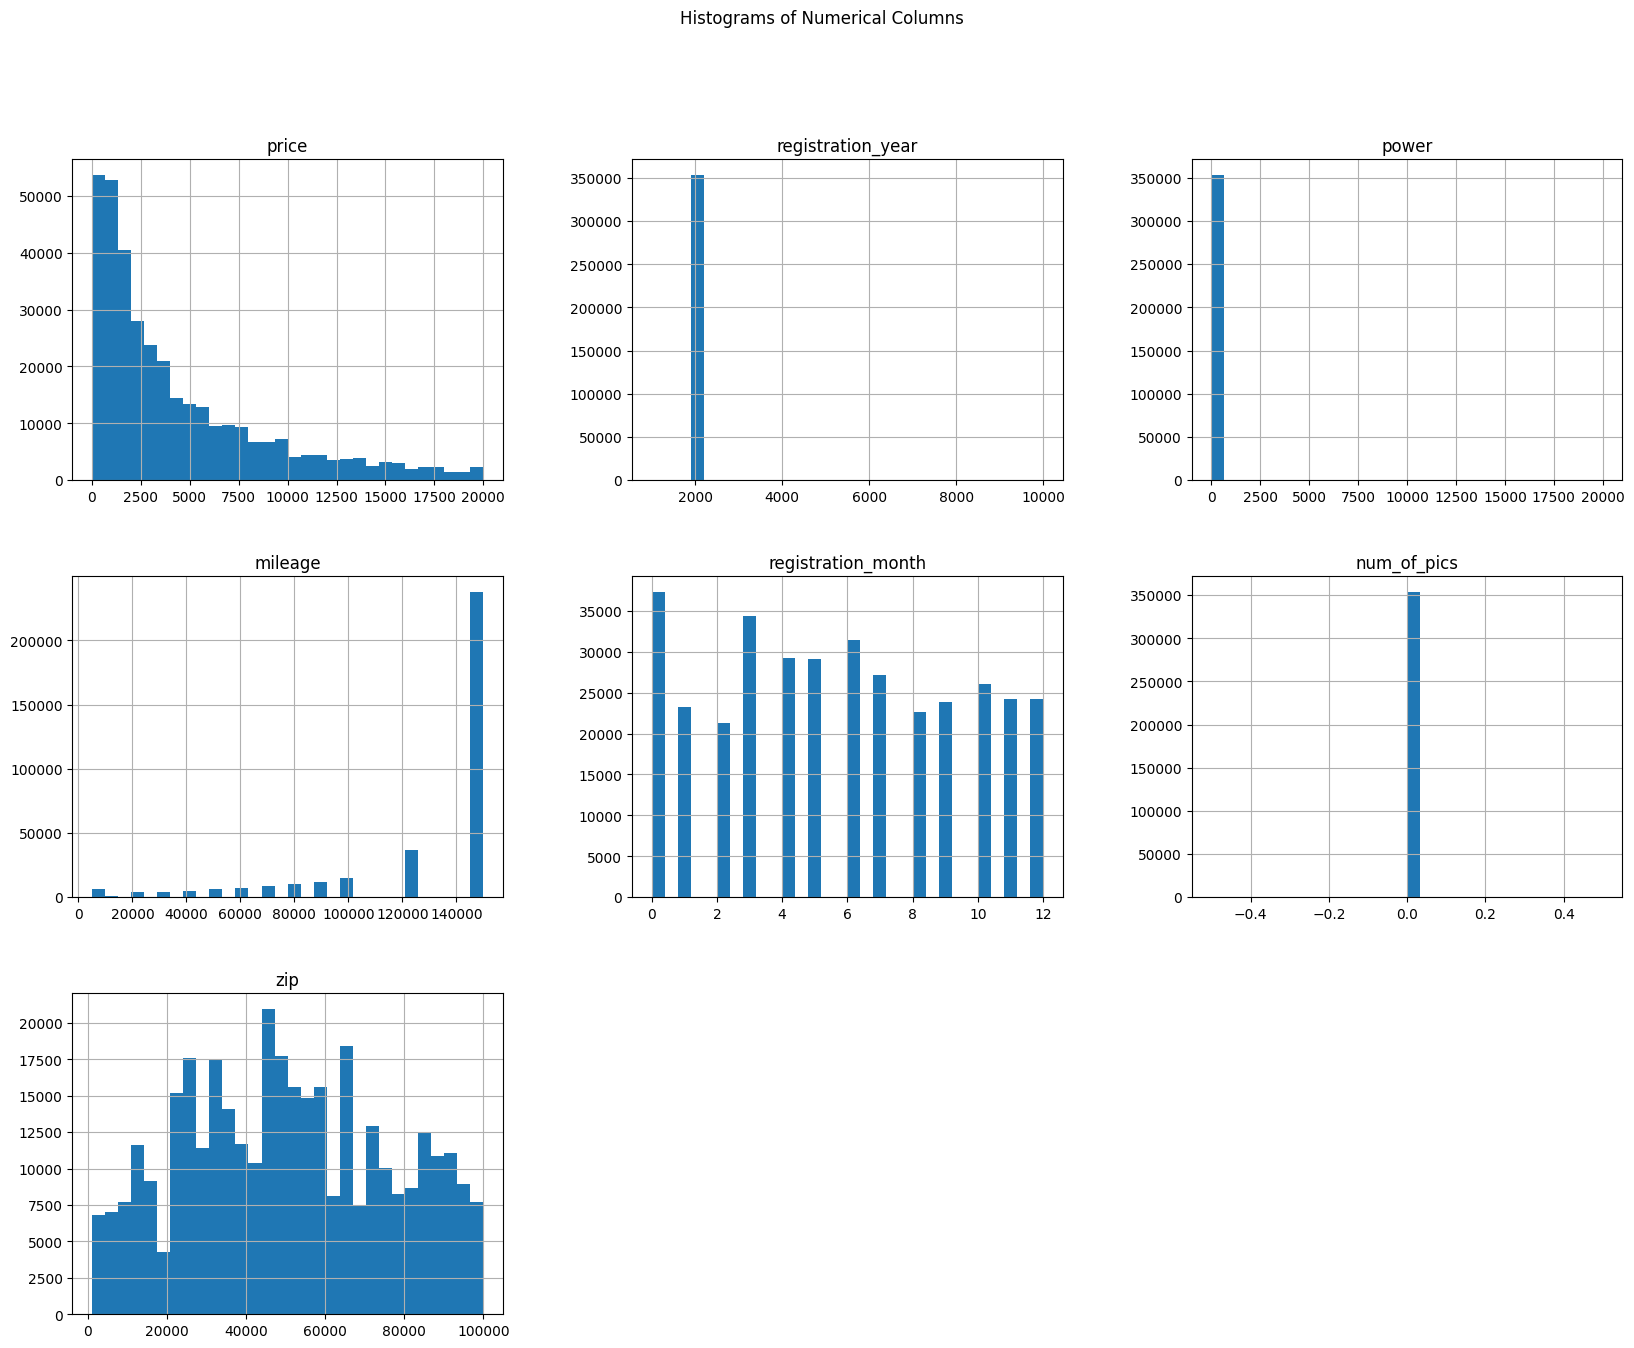

In [59]:
# Histograms for Numerical Data
df[numerical_columns].hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

Not much we can gather here except that most vehicles sold for under 2500 Euro. 

We'll look at our categorical data using count plots. However, we will drop the date columns and separate out the 'model' column as it contains a large number of unique values and will need to be reduced to get a good visual. That chart will follow the remaining categories below. 

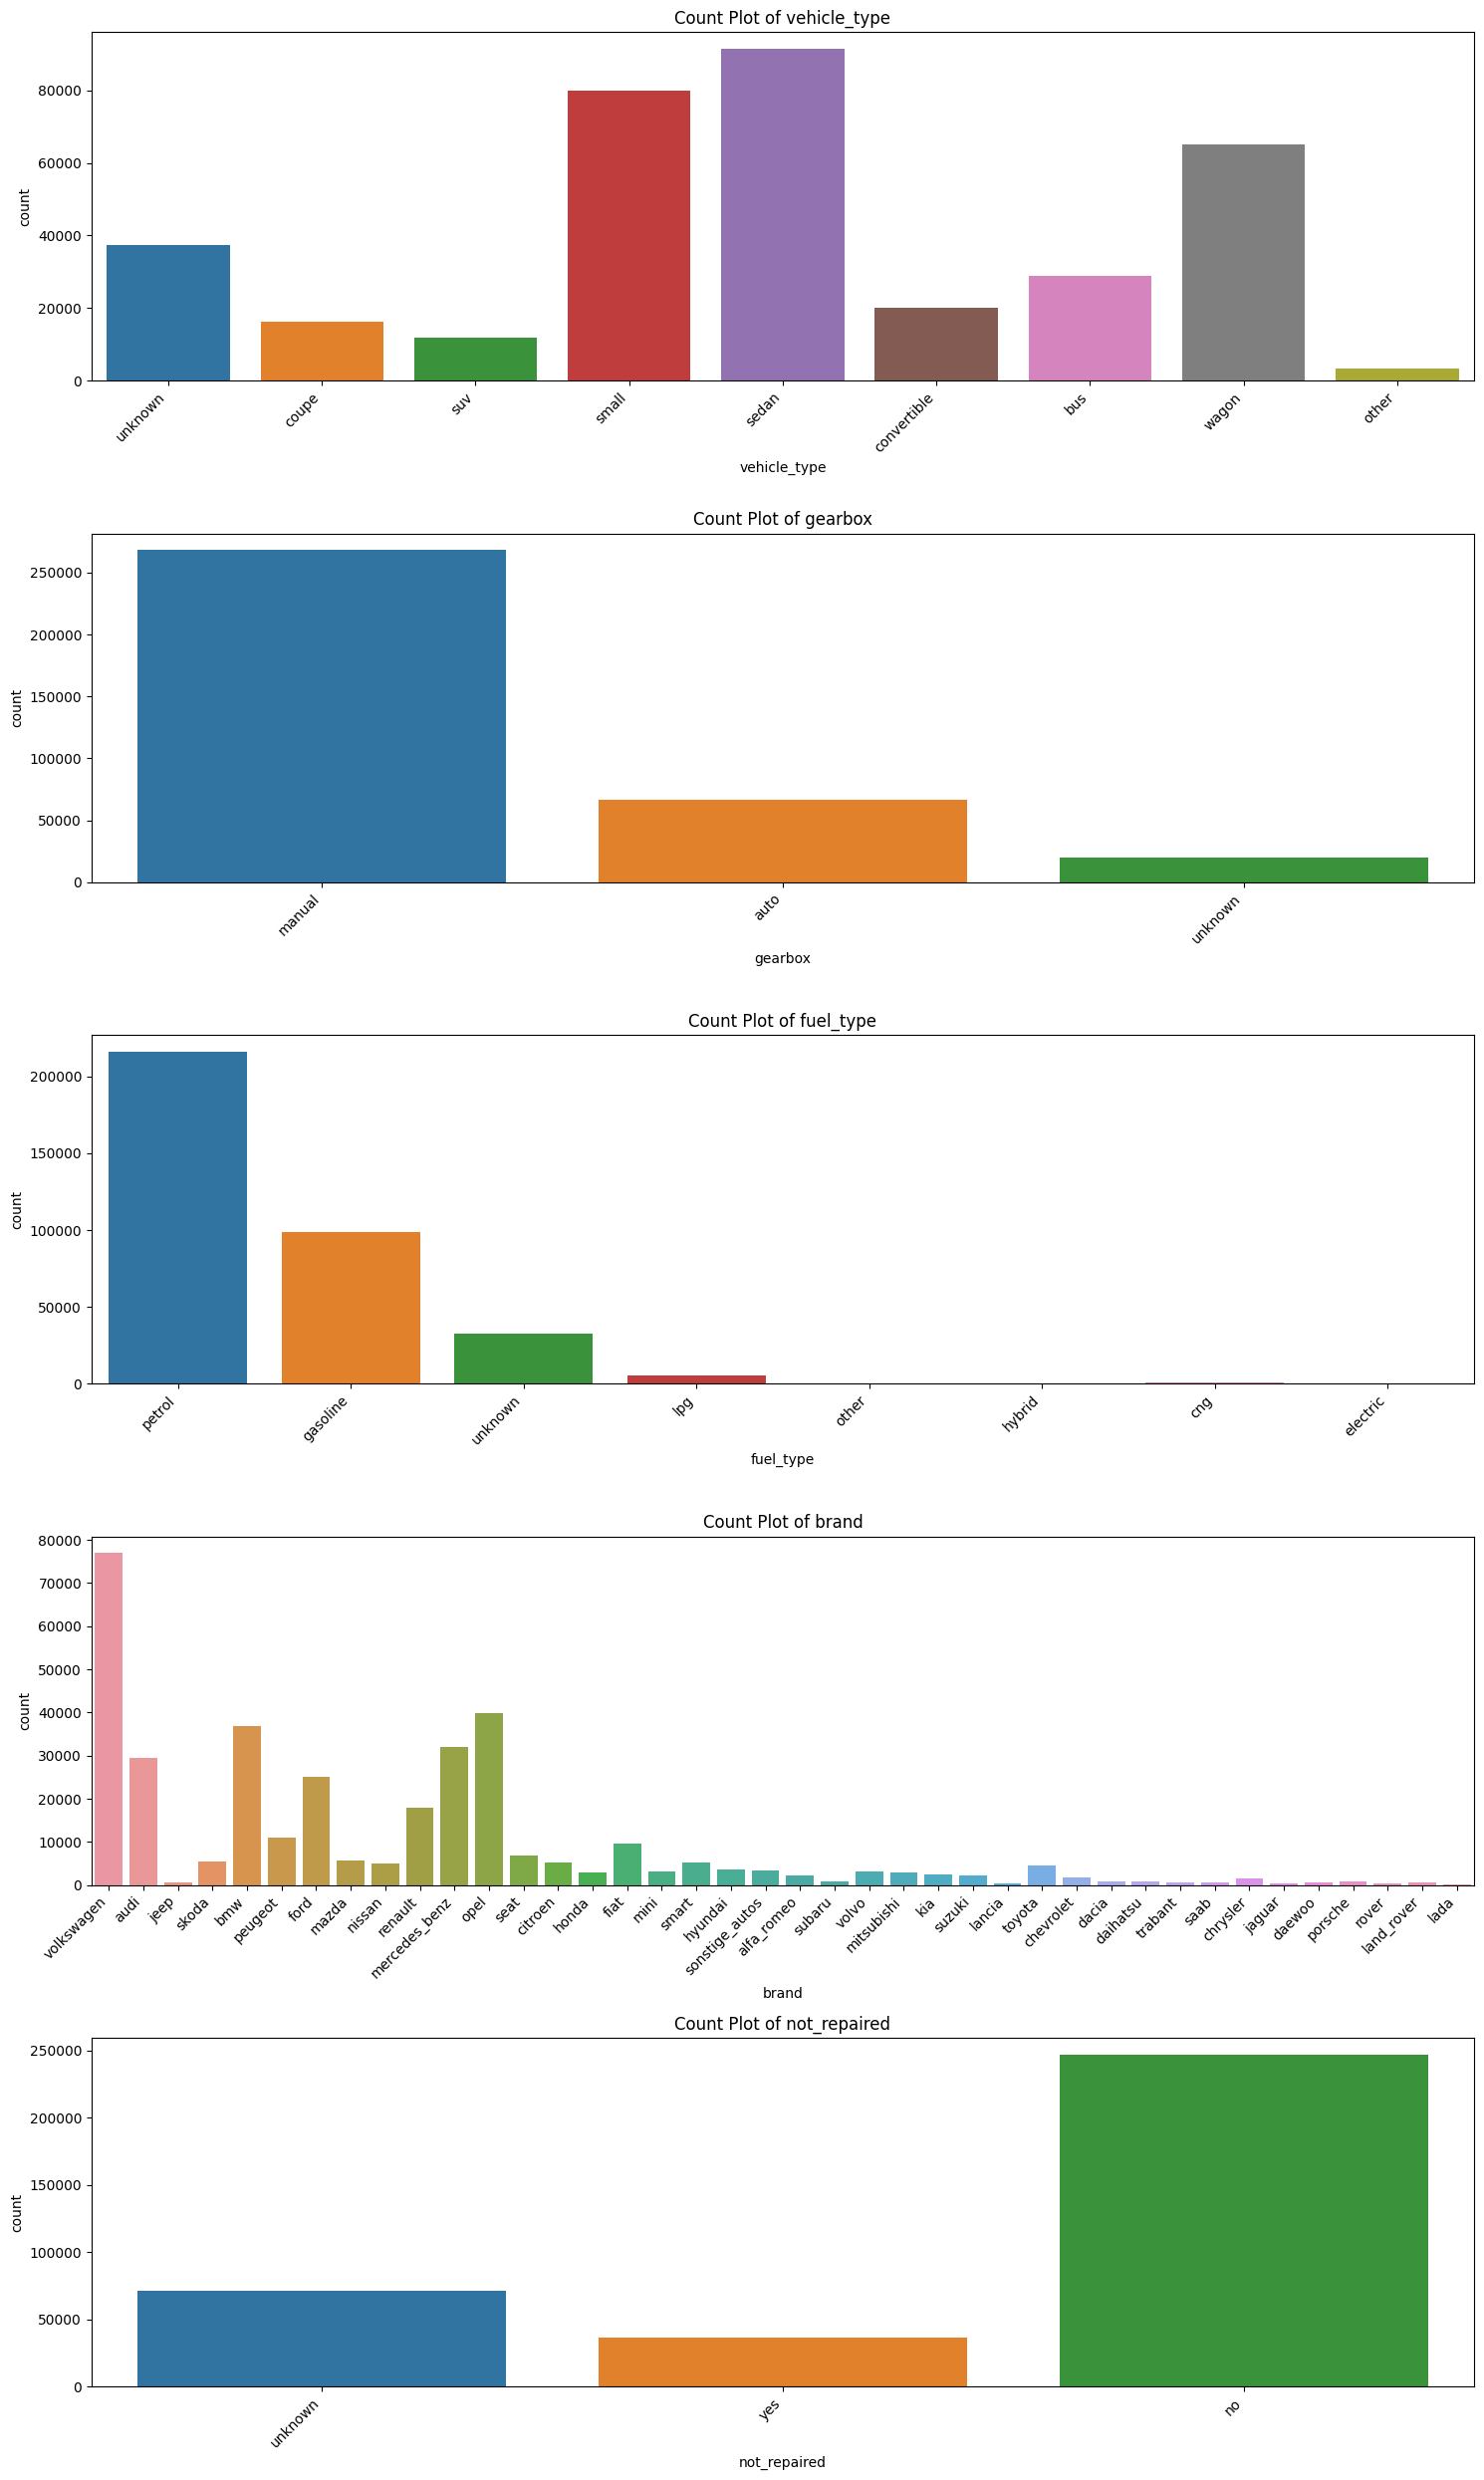

In [60]:
# Count Plots for Categorical Data

# Exclude the 'model' column and 'date' columns as there are too many to represent visually
date_columns = ['date_crawled', 'date_created', 'last_seen']
categorical_columns_2 = categorical_columns.drop(['model'] + date_columns)

fig, axes = plt.subplots(len(categorical_columns_2), 1, figsize=(15, 5 * len(categorical_columns_2)))

for col, ax in zip(categorical_columns_2, axes):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
plt.tight_layout()
plt.show()

In [61]:
# count number of unique values in the 'model' column.
df['model'].nunique()

251

Since our dataset is so large, it will be safe to filter models that have less than 1,000 entries. So that's what we'll do. 

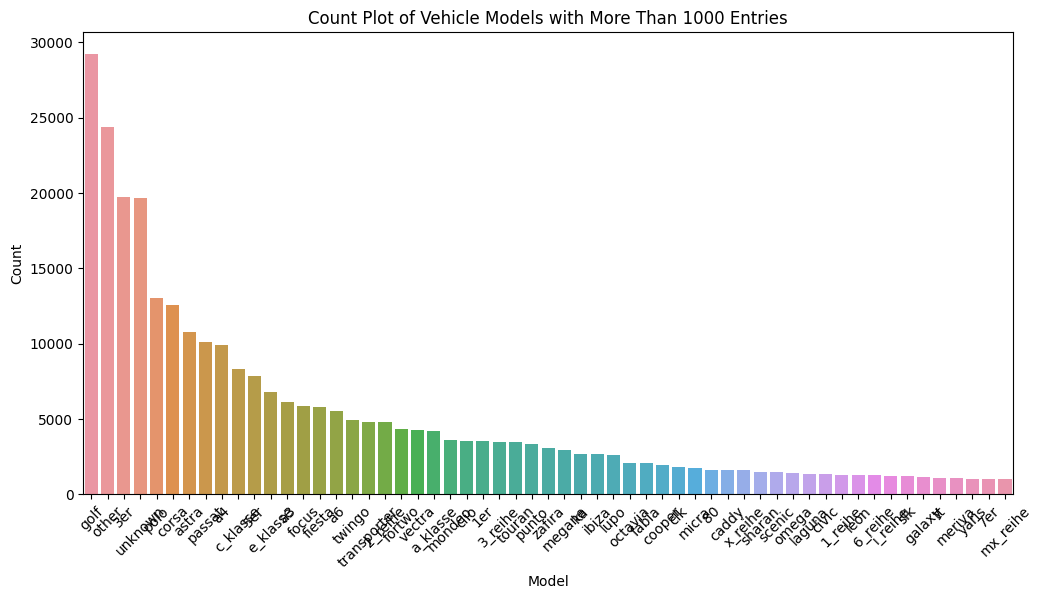

In [62]:
# Count the occurrences of each model
model_counts = df['model'].value_counts()

# Filter models with more than 1000 occurrences
models_above_threshold = model_counts[model_counts > 1000].index
filtered_df = df[df['model'].isin(models_above_threshold)]

# Create a count plot for these models
plt.figure(figsize=(12, 6))  # Adjust the size as needed
sns.countplot(data=filtered_df, x='model', order=models_above_threshold)
plt.title('Count Plot of Vehicle Models with More Than 1000 Entries')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

**Summary** With a quick look at our data we can see that most vehicles sold have been Volkswagen's models. Small sedans are the most common with typically over 140,000 miles and an average selling price of under 2500 Euro.

<br>

## Model training

In this section we will hypertune, train, and evaluate several machine learning models using various methods such as Optuna, GridSearchCV, RandomizedSearchCV, sampling, and gradient boosting. We'll train a Linear Regression model as our baseline model for the purpose of sanity checking our other models. 

**These are the models we will be training:** <br>
Linear regression <br>
decision tree<br>
random forest<br>
light gbm<br>
cat boost<br>

**Our steps are as follows:** <br>
Select our features and target variables from our filtered dataframe of models with 1000+ entries. <br>
Separate features into numerical and categorical values. <br>
Create 2 sets of categorical encoded data. One for Linear models using One Hot Encoding and one for tree based models using Label Encoding. <br>
Split our data into training, validation, and test sets. <br>
Scale numeric data using Standard Scaler. 

<br>

From there we will train our Linear Regression model. <br>
Tune and train Decision Tree model <br>
Tune and train Random Forest model <br>
Tune and train LightGBM model <br>
Tune and train CatBoost model <br>

In [63]:
# Select columns we want to use for modeling from our filtered dataframe

features = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'mileage', 'fuel_type', 'brand', 'not_repaired']
target = 'price'

In [64]:
# Declare features and target

x = filtered_df[features]
y = filtered_df[target]

In [65]:
filtered_df.shape

(292223, 16)

Now we'll separate them into categorical and numeric values for scaling and to use in different models.

In [66]:
# separate features into categorical and numeric features

categorical_features = x.select_dtypes(include=['object', 'category']).columns
numerical_features = x.select_dtypes(include=['int64']).columns

Let's take a look to make sure all of our features we want are there.

In [67]:
print(categorical_features)

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand',
       'not_repaired'],
      dtype='object')


In [68]:
print(numerical_features)

Index(['registration_year', 'power', 'mileage'], dtype='object')


**Encode Data**

Now we'll encode our categorical features using One Hot Encoding (OHE) for our Linear models.

In [69]:
x_ohe = pd.get_dummies(x, columns=categorical_features, drop_first=True).reset_index(drop=True)

Now let's split our OHE encoded data into training, validation, and test sets. 

In [70]:
# First Split: Train + Validation and Test (80% - 20%)
x_train_val_ohe, x_test_ohe, y_train_val_ohe, y_test_ohe = train_test_split(x_ohe, y, test_size=0.2, random_state=42)

In [71]:
# Second Split: Train and Validation (75% of 80% -> 60% total for training, 20% for validation)
x_train_ohe, x_val_ohe, y_train_ohe, y_val_ohe = train_test_split(x_train_val_ohe, y_train_val_ohe, test_size=0.25, random_state=42)

We'll also use Label Encoding for our tree based models. Let's go ahead and encode those categorical features.

In [72]:
from sklearn.preprocessing import LabelEncoder

x_label = x.copy()

categorical_features_label = x.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical features
label_encoders = {}
for col in categorical_features_label:
    le = LabelEncoder()
    x_label[col] = le.fit_transform(x_label[col])
    label_encoders[col] = le
    
# Reset index
x_label = x_label.reset_index(drop=True)

Now we'll split our label encoded data into training and testing sets.

In [73]:
# Split the label encoded data
x_train_val_label, x_test_label, y_train_val_label, y_test_label = train_test_split(x_label, y, test_size=0.2, random_state=42)
x_train_label, x_val_label, y_train_label, y_val_label = train_test_split(x_train_val_label, y_train_val_label, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Time to scale our numerical features using Standard Scaler.

In [74]:
# Make copies to avoid SettingWithCopyWarning
x_train_ohe = x_train_ohe.copy()
x_val_ohe = x_val_ohe.copy()
x_test_ohe = x_test_ohe.copy()

In [75]:
# Make copies to avoid SettingWithCopyWarning
x_train_label = x_train_label.copy()
x_val_label = x_val_label.copy()
x_test_label = x_test_label.copy()

In [76]:
# Apply scaling to OHE data
scaler_ohe = StandardScaler()
x_train_ohe[numerical_features] = scaler_ohe.fit_transform(x_train_ohe[numerical_features])
x_val_ohe[numerical_features] = scaler_ohe.transform(x_val_ohe[numerical_features])
x_test_ohe[numerical_features] = scaler_ohe.transform(x_test_ohe[numerical_features])

In [77]:
# Apply scaling to Label Encoded data
scaler_label = StandardScaler()
x_train_label[numerical_features] = scaler_label.fit_transform(x_train_label[numerical_features])
x_val_label[numerical_features] = scaler_label.transform(x_val_label[numerical_features])
x_test_label[numerical_features] = scaler_label.transform(x_test_label[numerical_features])

Now that our data is preprocessed for machine learning, we'll begin training our models.

In [78]:
import time
import optuna

**Linear Regression (Sanity Check)**

In [79]:
%%time

# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(x_train_ohe, y_train_ohe)

# predict and evaluate
y_pred_lr = model_lr.predict(x_val_ohe)
rmse_lr = mean_squared_error(y_val_ohe, y_pred_lr, squared=False)

print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression RMSE: 3204.4832827027767
CPU times: user 4.73 s, sys: 599 ms, total: 5.33 s
Wall time: 5.29 s


Our baseline model is giving us an RMSE score of 3204.48 in 5.33 seconds. We want to make sure our following models give us a lower RMSE score with a quick training and prediction time. 

**Hyperparameter Tuning & Training of Models**

**Decision Tree** <br>

We'll find best parameters for our Decision Tree model using Optuna, an automatic hyperparameter tuning software in Python. More information on it can be found here: https://optuna.readthedocs.io/en/stable/

In [111]:
# Find best parameters of Decision Tree model using Optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Objective function for decision tree - needed for optuna
def objective_decision_tree(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }
    model_dt = DecisionTreeRegressor(**params, random_state=42)
    model_dt.fit(x_train_label, y_train_label)
    y_pred_dt = model_dt.predict(x_val_label)
    rmse = mean_squared_error(y_val_label, y_pred_dt, squared=False)
    
    return rmse

# Perform hyperparameter optimization for Decision Tree
study_name = 'decision_tree_study'
study_dt = optuna.create_study(direction='minimize', study_name=study_name)
study_dt.optimize(objective_decision_tree, n_trials=50)
best_params_dt = study_dt.best_params

# Print the best parameters
print("Best hyperparameters for Decision Tree:")
print(best_params_dt)

Best hyperparameters for Decision Tree:
{'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 11}


Now that our best parameters are found, we'll train our decision tree on these params.

In [113]:
# Train and Evaluate Decision Tree model with best parameters

model_dt = DecisionTreeRegressor(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    min_samples_leaf=best_params_dt['min_samples_leaf'],
    random_state=42
)

# Train the model
model_dt.fit(x_train_label, y_train_label)

# Predict on the validation set
y_val_pred_dt = model_dt.predict(x_val_label)

# Calculate RMSE
val_rmse_dt = mean_squared_error(y_val_label, y_val_pred_dt, squared=False)
print(f"Decision Tree RMSE on validation set: {val_rmse_dt}")


start_time = time.time()
# Code to time
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

Decision Tree RMSE on validation set: 1863.0028622411119
Execution time: 3.3855438232421875e-05 seconds


Our Decision Tree model is quite good with a lower RMSE score than our baseline Linaer Regression model and faster execution time.

<br>

#### Random Forest

Since our dataset is quite large, we'll use a sample of our data to hypertune and train the Random Forest Regressor to save on computational time.

We'll use RandomizedSearchCV to find the best parameters.

In [82]:
x_train_sampled, _, y_train_sampled, _ = train_test_split(x_train_label, y_train_label, test_size=0.1, random_state=42)

In [83]:
# Train Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


# Define parameters
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt'],
    'max_depth': [10, 15]
}
    
# Initialize model    
model_rf = RandomForestRegressor(random_state=42)

# Perform Search
random_search_rf = RandomizedSearchCV(estimator=model_rf, param_distributions=param_dist_rf, n_iter=4, cv=3, n_jobs=-1, random_state=42, verbose=2)
random_search_rf.fit(x_train_sampled, y_train_sampled)

# Get best parameters
best_params_rf = random_search_rf.best_params_
print("Best hyperparameters found:")
print(best_params_rf)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   7.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   8.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   7.8s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=  11.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=  11.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=  11.6s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=  11.1s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=  11.4s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=  11.1s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=  17.0s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=  16.8s
[CV] END ..max_depth=15, max_features=sqrt, n_est

In [84]:
%%time

# Predict and evaluate Random Forest model on sample dataset
model_rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_features=best_params_rf['max_features'],
    max_depth=best_params_rf['max_depth'],
    random_state=42
)


model_rf.fit(x_train_label, y_train_label)

y_pred_full = model_rf.predict(x_val_label)
rmse_rf_full = mean_squared_error(y_val_label, y_pred_full, squared=False)
print(f"RMSE on full validation data: {rmse_rf_full}")

RMSE on full validation data: 1691.4819028636998
CPU times: user 27.6 s, sys: 108 ms, total: 27.7 s
Wall time: 27.9 s


The Random Forest Regressor took quite a bit of trial and error to get the hyperparameter tuning and training objectives we have here. Since it is a forest of trees and with a large dataset, we had to first use a smaller sample of our data to tune our model then run numerous trials to find the best parameters to use to keep our kernel from dying. In this, we found that it was best to keep our n_estimators under 200 for timing purposes, max_features 'sqrt' was better than 'auto', and max_depth was reduced to 15. 
We did get a lower RMSE score than the Decision Tree and Linear Regression models, however, speed is a factor for this project so let's see if another model can do better. 

<br>

#### Light GBM

Let's take a look at LightGBM model. It is known to work well with large datasets and faster to train than Random Forest models. It can also process unencoded data. To keep our models uniform, we'll use label encoded data.
To tune our LightGBM model we'll use GridSearchCV. 

In [85]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [86]:

model_lgb = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
}

grid_search_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search_lgb.fit(x_train_label, y_train_label)

# Get best parameters
best_params_lgb = grid_search_lgb.best_params_
print("Best hyperparameters found for LightGBM:")
print(best_params_lgb)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   1.4s
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   1.9s
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=31; total time=   1.4s
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=50; total time=   1.6s
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=50; total time=   1.6s
[CV] END .learning_rate=0.01, n_estimators=50, num_leaves=50; total time=   1.6s
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=   2.5s
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=   3.0s
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=   2.6s
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=50; total time=   3.0s
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=50; total time=   3.4s
[CV] END learning_rate=0.01, n_estimators=100, nu

In [87]:
%%time

# Train the LightGBM model with the best parameters
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb, random_state=42)
best_model_lgb.fit(x_train_label, y_train_label)

# Predict on the validation set
y_val_pred_lgb = best_model_lgb.predict(x_val_label)
val_rmse_lgb = mean_squared_error(y_val_label, y_val_pred_lgb, squared=False)
print(f"LightGBM RMSE on validation set: {val_rmse_lgb}")


LightGBM RMSE on validation set: 1733.8196406346603
CPU times: user 4.37 s, sys: 28.2 ms, total: 4.4 s
Wall time: 4.42 s


The LightGBM model certainly tuned and trained the fastest compared to our Decision Tree and Random Forest models. We get a lower RMSE score than the LinearRegression and Decision Tree models but slightly higher than Random Forest. However, we have to take into account the training time which was much faster than Random Forest model so the small difference in RMSE scores is not enough to discard the LightGBM model. So far, LightGBM is our best model for our dataset. 

<br>

**CatBoost** <br>
CatBoost is another gradient boosting library. It can handle categorical features automatically without the need for encoding and uses a symmetric tree structure which helps reduce overfitting. 
We'll use Optuna for parameter tuning. 

Through some trial and error, we found that the tree based models can take quite a bit of time and memory to tune. So for this model we will find the best parameters using a sample of our dataset like we did with Random Forest.

In [88]:
# Sample the data (10% of the original data)
sample_fraction = 0.1
x_train_sampled, _, y_train_sampled, _ = train_test_split(
    x_train_label, y_train_label, test_size=1-sample_fraction, random_state=42)

x_val_sampled, _, y_val_sampled, _ = train_test_split(
    x_val_label, y_val_label, test_size=1-sample_fraction, random_state=42)

In [89]:
# define Optuna Objective Function
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'verbose': 0
    }
    
    model_cb = CatBoostRegressor(**params, random_seed=42)
    model_cb.fit(x_train_sampled, y_train_sampled, eval_set=(x_val_sampled, y_val_sampled), early_stopping_rounds=50, verbose=0)
    
    y_val_pred_cb = model_cb.predict(x_val_sampled)
    val_rmse_cb = mean_squared_error(y_val_sampled, y_val_pred_cb, squared=False)
    
    return val_rmse_cb

In [90]:
# Perform hyperparameter optimization for CatBoost
study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_catboost, n_trials=50)

# Get the best parameters from Optuna
best_params_cb = study_cb.best_params
print("Best hyperparameters found for CatBoost:")
print(best_params_cb)

Best hyperparameters found for CatBoost:
{'iterations': 434, 'depth': 6, 'learning_rate': 0.23381332728368662}


In [91]:
%%time

# Train model with best params

# Initialize the CatBoost model with the best parameters
model_cb = CatBoostRegressor(**best_params_cb, random_seed=42)

# Train the model
model_cb.fit(x_train_label, y_train_label, eval_set=(x_val_label, y_val_label), early_stopping_rounds=50, verbose=100)

# Predict and evaluate the model
y_val_pred_cb = model_cb.predict(x_val_label)
val_rmse_cb = mean_squared_error(y_val_label, y_val_pred_cb, squared=False)
print(f"CatBoost RMSE on validation set: {val_rmse_cb}")

0:	learn: 3757.4233256	test: 3760.4016233	best: 3760.4016233 (0)	total: 44.7ms	remaining: 19.4s
100:	learn: 1754.7410128	test: 1783.0163222	best: 1783.0163222 (100)	total: 3.52s	remaining: 11.6s
200:	learn: 1681.1558816	test: 1735.1567532	best: 1735.0823130 (199)	total: 6.99s	remaining: 8.11s
300:	learn: 1638.1768426	test: 1713.0319585	best: 1713.0319585 (300)	total: 10.4s	remaining: 4.61s
400:	learn: 1609.0982490	test: 1701.9647964	best: 1701.9647964 (400)	total: 13.8s	remaining: 1.14s
433:	learn: 1600.6216100	test: 1700.1659402	best: 1700.1617427 (432)	total: 14.9s	remaining: 0us

bestTest = 1700.161743
bestIteration = 432

Shrink model to first 433 iterations.
CatBoost RMSE on validation set: 1700.1617426745227
CPU times: user 15.1 s, sys: 15.7 ms, total: 15.1 s
Wall time: 15.3 s


For our CatBoost model we get a similar RMSE score to our previous 2 models. It's lower than LightGBM and higher than RMSE but not enough to make them not comparable. Since this model also took some time with our large dataset, LightGBM still works best with our data. 

## Model analysis

For this section we'll go ahead and run each model on our test data to find the best RMSE scores. Then we'll compare the models based on their RMSE scores and their computational times for training and model predictions. 

In [114]:
# Evaluate Decision Tree
y_pred_dt = model_dt.predict(x_test_label)
rmse_dt = mean_squared_error(y_test_label, y_pred_dt, squared=False)
print(f"Decision Tree RMSE: {rmse_dt}")

Decision Tree RMSE: 1872.6860430083334


In [93]:
# Evaluate Random Forest
y_pred_rf = model_rf.predict(x_test_label)
rmse_rf = mean_squared_error(y_test_label, y_pred_rf, squared=False)
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 1707.4035435510607


In [96]:
# Evaluate LightGBM
y_pred_lgb = best_model_lgb.predict(x_test_label)
rmse_lgb = mean_squared_error(y_test_label, y_pred_lgb, squared=False)
print(f"LightGBM RMSE: {rmse_lgb}")

LightGBM RMSE: 1747.5385309840199


In [97]:
# Evaluate CatBoost
y_pred_cb = model_cb.predict(x_test_label)
rmse_cb = mean_squared_error(y_test_label, y_pred_cb, squared=False)
print(f"CatBoost RMSE: {rmse_cb}")

CatBoost RMSE: 1713.2448239645657


In [107]:
print(f"Decision Tree RMSE: {rmse_dt}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"LightGBM RMSE: {rmse_lgb}")
print(f"CatBoost RMSE: {rmse_cb}")

# Select the best model based on RMSE
best_model_name = min(
    [('Decision Tree', rmse_dt),
    ('Random Forest', rmse_rf), 
     ('LightGBM', rmse_lgb), 
     ('CatBoost', rmse_cb)], 
    key=lambda x: x[1]
)[0]
print(f"Best Model: {best_model_name}")

Decision Tree RMSE: 1872.645624016985
Random Forest RMSE: 1707.4035435510607
LightGBM RMSE: 1747.5385309840199
CatBoost RMSE: 1713.2448239645657
Best Model: Random Forest


In [115]:

# Initialize lists to store results
model_names = []
training_times = []
prediction_times = []
rmses = []

# Function to measure training and prediction time
def measure_time_and_rmse(model, model_name, x_train, y_train, x_val, y_val, x_test, y_test):
    # Measure training time
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    
    # Measure prediction time on validation set
    start_time = time.time()
    y_val_pred = model.predict(x_val)
    prediction_time_val = time.time() - start_time
    
    # Calculate RMSE on validation set
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    
    # Measure prediction time on test set
    start_time = time.time()
    y_test_pred = model.predict(x_test)
    prediction_time_test = time.time() - start_time
    
    # Calculate RMSE on test set
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store results
    model_names.append(model_name)
    training_times.append(training_time)
    prediction_times.append(prediction_time_val)
    rmses.append(test_rmse)
    
    return training_time, prediction_time_val, test_rmse

# Define models with best parameters
best_model_dt = DecisionTreeRegressor(**best_params_dt, random_state=42)
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb, random_state=42)
best_model_cb = CatBoostRegressor(**best_params_cb, random_state=42, verbose=0) 

# Measure time and RMSE for each model
measure_time_and_rmse(best_model_dt, "Decision Tree", x_train_label, y_train_label, x_val_label, y_val_label, x_test_label, y_test_label)
measure_time_and_rmse(best_model_rf, "Random Forest", x_train_label, y_train_label, x_val_label, y_val_label, x_test_label, y_test_label)
measure_time_and_rmse(best_model_lgb, "LightGBM", x_train_label, y_train_label, x_val_label, y_val_label, x_test_label, y_test_label)
measure_time_and_rmse(best_model_cb, "CatBoost", x_train_label, y_train_label, x_val_label, y_val_label, x_test_label, y_test_label)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Model": model_names,
    "Training Time (s)": training_times,
    "Prediction Time (s)": prediction_times,
    "RMSE": rmses
})

# Print results
print(results_df)

           Model  Training Time (s)  Prediction Time (s)         RMSE
0  Decision Tree           0.695003             0.017453  1872.686043
1  Random Forest          26.588338             1.862727  1707.403544
2       LightGBM           3.072457             0.616723  1747.538531
3       CatBoost          14.302993             0.037725  1713.152759


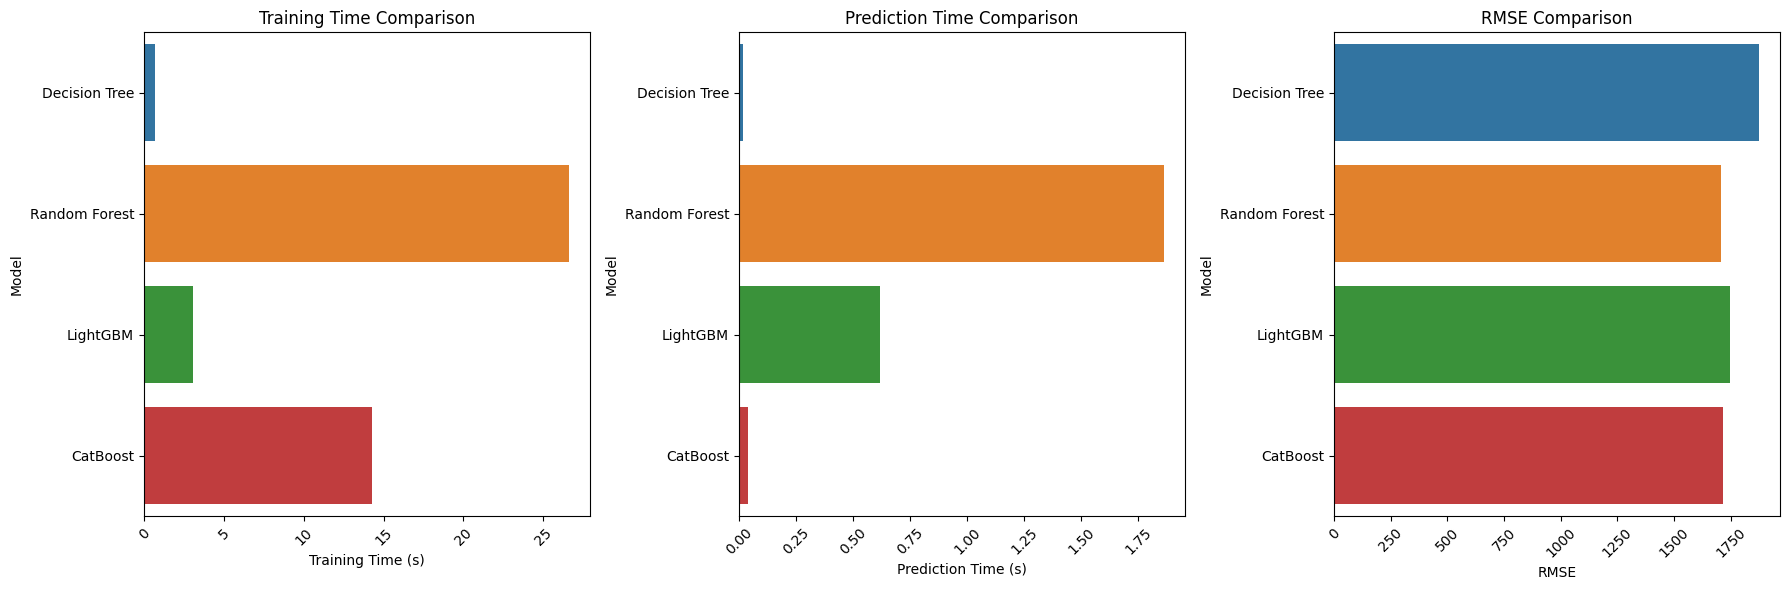

In [116]:
# Plot the results
plt.figure(figsize=(18, 6))

# Plot training times
plt.subplot(1, 3, 1)
sns.barplot(y="Model", x="Training Time (s)", data=results_df)
plt.title("Training Time Comparison")
plt.xticks(rotation=45)

# Plot prediction time
plt.subplot(1, 3, 2)
sns.barplot(y="Model", x="Prediction Time (s)", data=results_df)
plt.title("Prediction Time Comparison")
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(1, 3, 3)
sns.barplot(y="Model", x="RMSE", data=results_df)
plt.title("RMSE Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Conclusion

**Data Preparation** <br>
Our data preparation phase has been successfully completed. We began by importing the necessary libraries and uploading the dataset. To ensure consistency and uniformity across the dataset, we standardized column names to all lowercase. Missing values were handled by filling them with the label "Unknown," and duplicate entries were removed to maintain data integrity.


**Exploratory Data Analysis** (EDA) <br>
The exploratory data analysis (EDA) provided valuable insights into our dataset. The analysis revealed that the majority of vehicles sold were from the Volkswagen brand, highlighting its dominance in the market. The most common vehicle type was small sedans, which typically had high mileage—over 140,000 miles—and an average selling price below 2,500 Euro. These findings offer a clear picture of the market trends and characteristics of the vehicles within our dataset.


**Model Analysis and Performance** <br>
We evaluated four different machine learning models—Decision Tree, Random Forest, LightGBM, and CatBoost—for regression tasks using our dataset. The goal was to identify the most effective model based on RMSE (Root Mean Squared Error), training time, and prediction time.

<u>The Decision Tree model</u>, while the fastest in terms of both training and prediction times, exhibited the highest RMSE. This indicates that although it operates quickly, it is not suitable for our task requiring high predictive accuracy.

<u>Random Forest</u> achieved the lowest RMSE, making it the most accurate model among those tested. However, it had the longest training and prediction times, making it unsuitable for our real-time application needed.

<u>LightGBM</u> provided a competitive RMSE and significantly shorter training time compared to Random Forest, while its prediction time was also reasonable. This model strikes a good balance between accuracy and computational efficiency.

<u>CatBoost</u> offered the fastest prediction time, which is beneficial for real-time applications, but it had a higher training time compared to LightGBM. Its RMSE was slightly higher than Random Forest but better than LightGBM.



Based on these results, **LightGBM** model is the preferred model for this particular dataset. It strikes an effective balance between training time, prediction time, and accuracy, making it most suitable for our application. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

You did a brilliant job! Everything is correct and looks nice. I like your work:)

</div>